In [18]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

from wordcloud import WordCloud

import os

In [20]:
train = pd.read_csv('Z:\\VS Project\\HDAT\\PCOR\\npl-data\\train.csv')
test = pd.read_csv('Z:\\VS Project\\HDAT\\PCOR\\npl-data\\test.csv')
sample_submission = pd.read_csv('Z:\\VS Project\\HDAT\\PCOR\\npl-data\\sample_submission.csv')
print("Successfully Loaded")

Successfully Loaded


In [21]:
train.head(), train.shape, test.head(), test.shape, sample_submission.head()

(   id keyword location                                               text  \
 0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
 1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
 2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
 3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
 4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   
 
    target  
 0       1  
 1       1  
 2       1  
 3       1  
 4       1  ,
 (7613, 5),
    id keyword location                                               text
 0   0     NaN      NaN                 Just happened a terrible car crash
 1   2     NaN      NaN  Heard about #earthquake is different cities, s...
 2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
 3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
 4  11     NaN      NaN      Typhoon Soudelor kills 28 in China 

In [22]:
# NOT a disaster tweet.
train[train["target"] == 0]["text"].values[1]

'I love fruits'

In [23]:
# A disaster tweet
train[train["target"] == 1]["text"].values[1]

'Forest fire near La Ronge Sask. Canada'

In [24]:
# Not NaN keyword
train[train["keyword"].notna()]["keyword"].values[1]

'ablaze'

In [25]:
# Not NaN location
train[train["location"].notna()]["location"].values[1]

'Est. September 2012 - Bristol'

In [26]:
def create_corpus(tweet):
    corpus=[]
    
    # Gather target word
    for x in tweet[tweet['target']==1]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

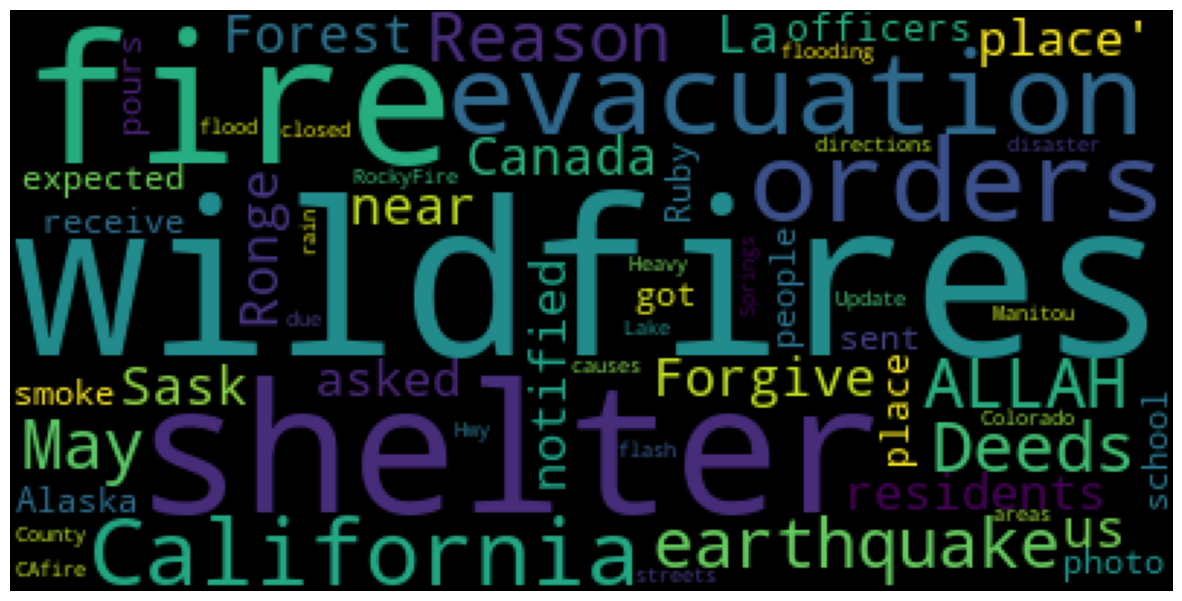

In [27]:
corpus = create_corpus(train)

plt.figure(figsize=(15, 10))
word_cloud = WordCloud(max_font_size=80).generate(" ".join(corpus[:100]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [28]:
# convert all words to small letter (Ex: Typhoon -> typhoon)
train["text"] = train["text"].str.lower()

train.loc[0, "text"]

'our deeds are the reason of this #earthquake may allah forgive us all'

In [29]:
# Devide train data into train (80%) and validation (20%)
# X = train["text"]
# Y = train["target"]

# X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
# trainデータフレームを特徴量とターゲットに分割
X_train, X_val, Y_train, Y_val = train_test_split(train[["text"]], train["target"], test_size=0.2, random_state=42)

X_test = test["text"]

X_train.head(), Y_train.head()

(                                                   text
 4996  courageous and honest analysis of need to use ...
 3263  @zachzaidman @670thescore wld b a shame if tha...
 4907  tell @barackobama to rescind medals of 'honor'...
 2855  worried about how the ca drought might affect ...
 4716  @youngheroesid lava blast &amp; power red #pan...,
 4996    1
 3263    0
 4907    1
 2855    1
 4716    0
 Name: target, dtype: int64)

In [30]:
count_vectorizer = feature_extraction.text.CountVectorizer()

## let's get counts for the first 5 tweets in the data
example_train_vectors = count_vectorizer.fit_transform(X_train["text"][0:5])

In [31]:
## we use .todense() here because these vectors are "sparse" (only non-zero elements are kept to save space)
print(example_train_vectors[0].todense().shape)
print(example_train_vectors[0].todense())

(1, 75)
[[1 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0
  1 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0
  0 0 0]]


In [32]:
train_vectors = count_vectorizer.fit_transform(X_train["text"])

## note that we're NOT using .fit_transform() here. Using just .transform() makes sure
# that the tokens in the train vectors are the only ones mapped to the test vectors - 
# i.e. that the train and test vectors use the same set of tokens.
test_vectors = count_vectorizer.transform(test["text"])

In [33]:
## Our vectors are really big, so we want to push our model's weights
## toward 0 without completely discounting different words - ridge regression 
## is a good way to do this.
clf = linear_model.RidgeClassifier()

In [34]:
scores = model_selection.cross_val_score(clf, train_vectors, Y_train, cv=3, scoring="f1")
scores

array([0.71227856, 0.72424429, 0.71869328])

In [35]:
clf.fit(train_vectors, Y_train)

RidgeClassifier()

In [36]:
sample_submission["target"] = clf.predict(test_vectors)

In [37]:
sample_submission.to_csv("submission.csv", index=False)